# Running Simulations

## Introduction

The purpose of this notebook is to demonstrate how to run CT simulations using open-source head phantoms as a part of **Aim 1.3**.

![](../project_aims.png)
*This notebook focuses on Aim 1.3, CT Dataset Generation Pipeline*

Previously for the [pilot study](https://github.com/bnel1201/Virtual-Patient-CT-Simulations/blob/PedSilicoICH-Pilot/pedsilico-pilot.ipynb) we demonstrated inserting simple circular lesions into an XCAT head phantom using the [XCIST simulation framework](https://github.com/xcist).

See their [Phys Med Bio article](https://iopscience.iop.org/article/10.1088/1361-6560/ac9174) for more

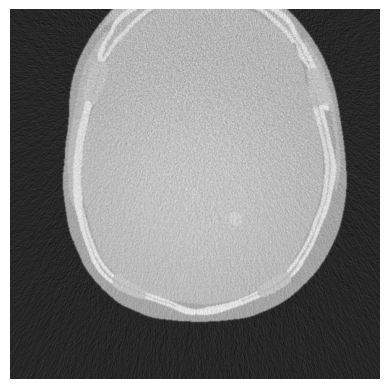

Data driven methods AI enables unprecedented innovation in medical devices and clinical practice by leveraging increasingly large data sources to solve previously intractable problems in medical imaging including image reconstruction, segmentation and classification. Further incorporating model-based machine learning which combines known physical and biological relationships fit with real data could further enable predictions having even great impact on clinical decision making (eg stroke intervention, or rad therapy). However, any data driven method is at risk of bias and over fitting on the sparse noisey training sets and then is liable to drift to ever changing data sources in production. Developing large, diverse high quality test sets is an important mitigation to model bias and drift but becomes when considering including rare diseases and underrepresented groups such as pediatrics into device development and evaluation. In addition to be rarer pediatrics have special protections on data access. Thus in silico modeling of patients, diseases, and imaging systems will be another essential mitigation factor enabling high quality labeled data where ground truth is known exactly and can be produced sustainably compared to traditional clinical trials and retrospective collection. 

This work aims to devloped in silico disease models of large vessel occlusions that can be modeled for pediatric evaluation of LVO cadt devices.


In [1]:
from dxcist.xcist_sims import run_simulation, get_projection_data, get_reconstructed_data

## Define the Phantom to be imaged

In [2]:
import nibabel as nib
from pathlib import Path
phantom_dir = Path('../MIDA Head Phantom')
img = nib.load(phantom_dir/'MIDA_v1.nii')

In [3]:
import matplotlib.pyplot as plt
import numpy as np

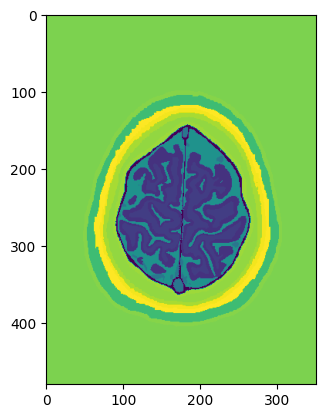

In [4]:
phantom = np.array(img.get_fdata()).transpose(1, 0, 2)
plt.imshow(phantom[-80])

Below is the look up table for each segment, next step is assigning each an appropriate linear attenuation coefficient then running through `run_simulation`

In [5]:
from io import StringIO
import pandas as pd
with open(phantom_dir / 'MIDA_v1.txt', 'rb') as data:
    df = pd.read_csv(StringIO(data.read().decode(errors='replace')), sep='\t', names=['grayscale','c1', 'c2', 'c3', 'material'])
    material_lut = df.iloc[:-8]
    temp = df.iloc[-8:, :2].set_index('grayscale').T
    nx, ny, nz, dx, dy, dz = temp.nx.item(), temp.ny.item(), temp.nz.item(), temp.dx.item()*1000, temp.dy.item()*1000, temp.dz.item()*1000
material_lut

,grayscale,c1,c2,c3,material
0,1,0.000000,0.988235,1.000000,Dura
1,2,1.000000,0.780392,0.000000,Cerebellum Gray Matter
2,3,0.658824,1.000000,1.000000,Pineal Body
3,4,0.000000,0.000000,1.000000,Amygdala
4,5,1.000000,0.423529,1.000000,Hippocampus
...,...,...,...,...,...
111,112,0.000000,1.000000,0.000000,Cranial Nerve IX - Glossopharyngeal
112,113,0.650980,0.376471,0.596078,Cranial Nerve X - Vagus
113,114,0.082353,0.458824,0.207843,Cranial Nerve XI - Accessory
114,115,1.000000,1.000000,0.000000,Cranial Nerve XII - Hypoglossal


My goal is to reproduce the steps done here: [open source XCIST demo](https://github.com/bnel1201/XCIST_demo/blob/main/opensource_peds_demo.ipynb) of assigning each labeled anatomy to an xcist material for converting to linear attenuation units

See also Wiki LUT for CT numbers: https://en.wikipedia.org/wiki/Hounsfield_scale

In [6]:
material_lut.material.unique()

array(['Dura', 'Cerebellum Gray Matter', 'Pineal Body', 'Amygdala',
       'Hippocampus', 'CSF Ventricles', 'Caudate Nucleus', 'Putamen',
       'Cerebellum White Matter', 'Brain Gray Matter',
       'Brainstem Midbrain', 'Brain White Matter', 'Spinal Cord',
       'Brainstem Pons', 'Brainstem Medulla', 'Nucleus Accumbens',
       'Globus Pallidus', 'Optic Tract', 'Hypophysis or Pituitary Gland',
       'Mammillary Body', 'Hypothalamus', 'Commissura (Anterior)',
       'Commissura (Posterior)', 'Blood Arteries', 'Blood Veins',
       'Air Internal - Ethmoidal Sinus', 'Air Internal - Frontal Sinus',
       'Air Internal - Maxillary Sinus',
       'Air Internal - Sphenoidal Sinus', 'Air Internal - Mastoid',
       'Air Internal - Nasal/Pharynx', 'CSF General', 'Ear Cochlea',
       'Ear Semicircular Canals', 'Ear Auricular Cartilage (Pinna)',
       'Mandible', 'Mucosa', 'Muscle (General)',
       'Nasal Septum (Cartilage)', 'Skull', 'Teeth', 'Tongue',
       'Adipose Tissue', 'Vertebra 

https://github.com/xcist/main/tree/master/gecatsim/material

In [7]:
from pathlib import Path
from utils import ctshow

In [8]:
material_lut.loc[material_lut.material=='Cerebellum Gray Matter', 'grayscale'] = 10
material_lut.loc[material_lut.material=='Cerebellum  Gray Matter', 'xcist material'] = 'gray_matter'
material_lut.loc[material_lut.material=='Cerebellum  Gray Matter', 'CT Number [HU]'] = 45

material_lut.loc[material_lut.material=='Brain Gray Matter', 'grayscale'] = 10
material_lut.loc[material_lut.material=='Brain Gray Matter', 'xcist material'] = 'gray_matter'
material_lut.loc[material_lut.material=='Brain Gray Matter', 'CT Number [HU]'] = 45

material_lut.loc[material_lut.material=='Thalamus', 'grayscale'] = 116
material_lut.loc[material_lut.material=='Thalamus', 'xcist material'] = 'gray_matter'
material_lut.loc[material_lut.material=='Thalamus', 'CT Number [HU]'] = 45

material_lut.loc[material_lut.material=='Cerebellum White Matter', 'grayscale'] = 12
material_lut.loc[material_lut.material=='Cerebellum White Matter', 'xcist material'] = 'white_matter'
material_lut.loc[material_lut.material=='Cerebellum White Matter', 'CT Number [HU]'] = 20

material_lut.loc[material_lut.material=='Brain White Matter', 'grayscale'] = 12
material_lut.loc[material_lut.material=='Brain White Matter', 'xcist material'] = 'white_matter'
material_lut.loc[material_lut.material=='Brain White Matter', 'CT Number [HU]'] = 20


material_lut.loc[material_lut.material=='CSF General', 'grayscale'] = 32
material_lut.loc[material_lut.material=='CSF General', 'xcist material'] = 'CSF'
material_lut.loc[material_lut.material=='CSF General', 'grayscale'] = 32
material_lut.loc[material_lut.material=='CSF General', 'CT Number [HU]'] = 15
material_lut.loc[material_lut.material=='CSF Ventricles', 'xcist material'] = 'CSF'
material_lut.loc[material_lut.material=='CSF Ventricles', 'CT Number [HU]'] = 15

material_lut.loc[material_lut.material=='Skull', 'grayscale'] = 62
material_lut.loc[material_lut.material=='Skull', 'xcist material'] = 'ncat_skull'
material_lut.loc[material_lut.material=='Skull', 'CT Number [HU]'] = 900

material_lut.loc[material_lut.material=='Skull Diplo�', 'grayscale'] = 52
material_lut.loc[material_lut.material=='Skull Diplo�', 'xcist material'] = 'ncat_skull'
material_lut.loc[material_lut.material=='Skull Diplo�', 'CT Number [HU]'] = 800 # https://en.wikipedia.org/wiki/Diplo%C3%AB

material_lut.loc[material_lut.material=='Skull Inner Table', 'grayscale'] = 52
material_lut.loc[material_lut.material=='Skull Inner Table', 'xcist material'] = 'ncat_skull'
material_lut.loc[material_lut.material=='Skull Inner Table', 'CT Number [HU]'] = 1000

material_lut.loc[material_lut.material=='Skull Outer Table', 'grayscale'] = 54
material_lut.loc[material_lut.material=='Skull Outer Table', 'xcist material'] = 'ncat_skull'
material_lut.loc[material_lut.material=='Skull Outer Table', 'CT Number [HU]'] = 1000

material_lut.loc[material_lut.material=='Adipose Tissue', 'grayscale'] = 62
material_lut.loc[material_lut.material=='Adipose Tissue', 'CT Number [HU]'] = -120

material_lut.loc[material_lut.material=='Muscle (General)', 'grayscale'] = 63
material_lut.loc[material_lut.material=='Muscle (General)', 'CT Number [HU]'] = 55

material_lut[~material_lut['CT Number [HU]'].isna()]

/tmp/ipykernel_14551/2949165353.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  material_lut.loc[material_lut.material=='Cerebellum  Gray Matter', 'xcist material'] = 'gray_matter'
/tmp/ipykernel_14551/2949165353.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  material_lut.loc[material_lut.material=='Cerebellum  Gray Matter', 'CT Number [HU]'] = 45


,grayscale,c1,c2,c3,material,xcist material,CT Number [HU]
5,6,0.368627,0.588235,0.549020,CSF Ventricles,CSF,15.0
8,12,0.713726,0.121569,0.341176,Cerebellum White Matter,white_matter,20.0
9,10,0.521569,0.521569,0.533333,Brain Gray Matter,gray_matter,45.0
11,12,1.000000,1.000000,1.000000,Brain White Matter,white_matter,20.0
31,32,0.411765,0.000000,0.000000,CSF General,CSF,15.0
37,63,0.450980,0.776471,0.125490,Muscle (General),NaN,55.0
39,62,1.000000,1.000000,0.588235,Skull,ncat_skull,900.0
42,62,0.690196,0.478431,1.000000,Adipose Tissue,NaN,-120.0
51,52,0.745098,0.000000,0.000000,Skull Diplo�,ncat_skull,800.0
52,52,0.309804,0.000000,0.294118,Skull Inner Table,ncat_skull,1000.0


In [9]:
material_lut[~material_lut['CT Number [HU]'].isna()].to_csv('material_lut.csv', index=False)

In [10]:
material_lut.loc[material_lut.material=='Muscle (General)']

,grayscale,c1,c2,c3,material,xcist material,CT Number [HU]
37,63,0.45098,0.776471,0.12549,Muscle (General),NaN,55.0


In [11]:
np.unique(phantom[150])

array([  1.,  15.,  24.,  25.,  28.,  31.,  32.,  36.,  37.,  38.,  39.,
        40.,  43.,  44.,  45.,  50.,  51.,  62.,  63.,  65.,  66.,  67.,
        68.,  70.,  74.,  75.,  77.,  78.,  81.,  82.,  89.,  97., 108.,
       112., 113., 114.])

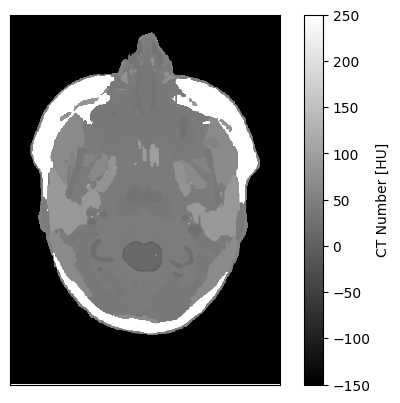

In [12]:
phantom[phantom == 50] = -1000 # air
for idx, row in material_lut[~material_lut['CT Number [HU]'].isna()].iterrows():
    phantom[phantom==row.grayscale] = row['CT Number [HU]']
im = ctshow(phantom[150])
plt.colorbar(im, label='CT Number [HU]')

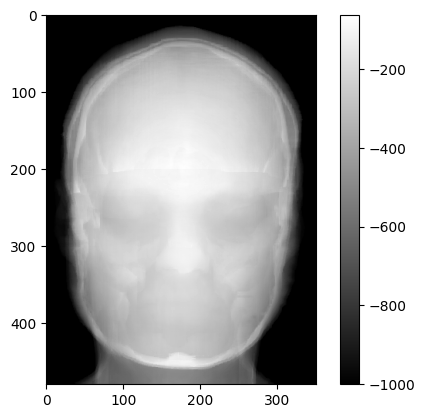

In [13]:
plt.imshow(phantom.mean(axis=1)[::-1], cmap='gray')
plt.colorbar()

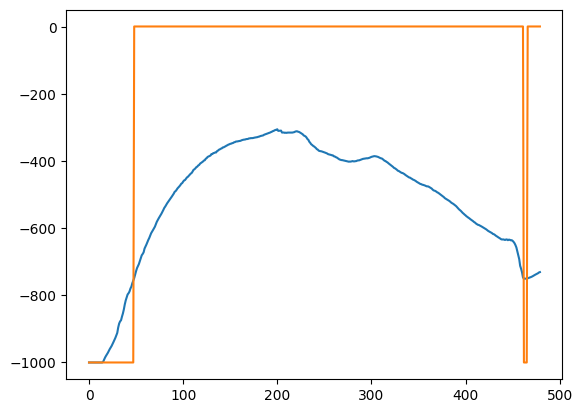

In [14]:
plt.plot(phantom.mean(axis=1)[::-1].mean(axis=1))
plt.plot(np.where(phantom.mean(axis=1)[::-1].mean(axis=1) > -750, 1, -1000))

In [15]:
nonair_projections = np.argwhere(phantom.mean(axis=1)[::-1].mean(axis=1) > -775).squeeze()
start_idx, end_idx = nonair_projections[0], nonair_projections[-1]
phantom = phantom[start_idx:end_idx]

In [16]:
from ipywidgets import interact, IntSlider

def scrollview(phantom):
    interact(lambda idx: ctshow(phantom[idx]), idx=IntSlider(value=phantom.shape[0]//2, min=0, max=phantom.shape[0]-1))
scrollview(phantom)

interactive(children=(IntSlider(value=217, description='idx', max=433), Output()), _dom_classes=('widget-inter…

A weakness with xcist is that it is a steep learning curve and minimally documented except for a few helpful doc strings. There is also limited ability to go from a ground truth voxeleized phantom to CT sim, need to convert to a stack of dicoms then run through DICOM_to_voxelized.py to get to their desired density file structure

Note: if doing 5 mm slices, then I can subsample this safely to 2 mm phantom slices (rather than currently 0.5 mm phantom slices) this will speed up computation time

ct = run_simulation(ground_truth_image=phantom[200:450], spacings=(dz, dx, dy), output_dir='test', fov=250)

Need to also update the thresholds in the [config file](https://github.com/xcist/phantoms-voxelized/blob/main/DICOM_to_voxelized/DICOM_to_voxelized_example_head.cfg) appropriately to get the best match in CT numbers (could do something like grab the unique values since I'm starting from groudn truth

Example of [normal brain CT](https://nbia.cancerimagingarchive.net/viewer/?study=1.3.6.1.4.1.14519.5.2.1.3098.5025.922017993220231365363448902707&series=1.3.6.1.4.1.14519.5.2.1.3098.5025.127673560102649811051571885155&token=eyJhbGciOiJIUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJkZGFhMGY3YS1kZTBmLTRkYWQtYjM1ZS05MjljYjBiMTY3YjgifQ.eyJleHAiOjE3MDQ0MDA4NDYsImlhdCI6MTcwNDM5MzY0NiwianRpIjoiZDU4YTI0M2YtNGQwZi00MjljLTg0NDQtMGI5MjJjNzUzNWQ0IiwiaXNzIjoiaHR0cHM6Ly9rZXljbG9hay5kYm1pLmNsb3VkL2F1dGgvcmVhbG1zL1RDSUEiLCJhdWQiOiJhY2NvdW50Iiwic3ViIjoiZjowMTliNTYzNC1kYWJkLTQyMTEtYTQxZC03MjNjNDRhZmNmZmQ6bmJpYV9ndWVzdCIsInR5cCI6IkJlYXJlciIsImF6cCI6Im5iaWEiLCJzZXNzaW9uX3N0YXRlIjoiYzc5OTIxMTItZjcyYS00OWY5LWI0ZTMtOWY3ZTFmN2I0NzQ5IiwiYWNyIjoiMSIsImFsbG93ZWQtb3JpZ2lucyI6WyJodHRwczovL3NlcnZpY2VzLmNhbmNlcmltYWdpbmdlYXJjaGl2ZS5uZXQiLCJodHRwczovL25iaWEuY2FuY2VyaW1hZ2luZ2VhcmNoaXZlLm5ldCIsImh0dHBzOi8vd3d3LmNhbmNlcmltYWdpbmdlYXJjaGl2ZS5uZXQiLCIqIiwiaHR0cDovL3RjaWEtbmJpYS0yLmFkLnVhbXMuZWR1OjQ1MjEwIiwiaHR0cHM6Ly9jYW5jZXJpbWFnaW5nZWFyY2hpdmUubmV0IiwiaHR0cDovL3RjaWEtbmJpYS0xLmFkLnVhbXMuZWR1OjQ1MjEwIiwiaHR0cHM6Ly9wdWJsaWMuY2FuY2VyaW1hZ2luZ2VhcmNoaXZlLm5ldCJdLCJyZWFsbV9hY2Nlc3MiOnsicm9sZXMiOlsib2ZmbGluZV9hY2Nlc3MiLCJkZWZhdWx0LXJvbGVzLXRjaWEiLCJ1bWFfYXV0aG9yaXphdGlvbiJdfSwicmVzb3VyY2VfYWNjZXNzIjp7ImFjY291bnQiOnsicm9sZXMiOlsibWFuYWdlLWFjY291bnQiLCJtYW5hZ2UtYWNjb3VudC1saW5rcyIsInZpZXctcHJvZmlsZSJdfX0sInNjb3BlIjoib3BlbmlkIHByb2ZpbGUgZW1haWwiLCJzaWQiOiJjNzk5MjExMi1mNzJhLTQ5ZjktYjRlMy05ZjdlMWY3YjQ3NDkiLCJlbWFpbF92ZXJpZmllZCI6dHJ1ZSwibmFtZSI6Ik5CSUEgR3Vlc3QiLCJwcmVmZXJyZWRfdXNlcm5hbWUiOiJuYmlhX2d1ZXN0IiwiZ2l2ZW5fbmFtZSI6Ik5CSUEiLCJmYW1pbHlfbmFtZSI6Ikd1ZXN0IiwiZW1haWwiOiJuYmlhX2d1ZXN0QGNhbmNlcmltYWdpbmdhcmNoaXZlLm5ldCJ9.q7c8o4AZK8cnCMYmZD_TjGvGyLIAZBysMJNIVV3agrE) for reference

recon = get_reconstructed_data(ct)
recon.shape

scrollview(recon)

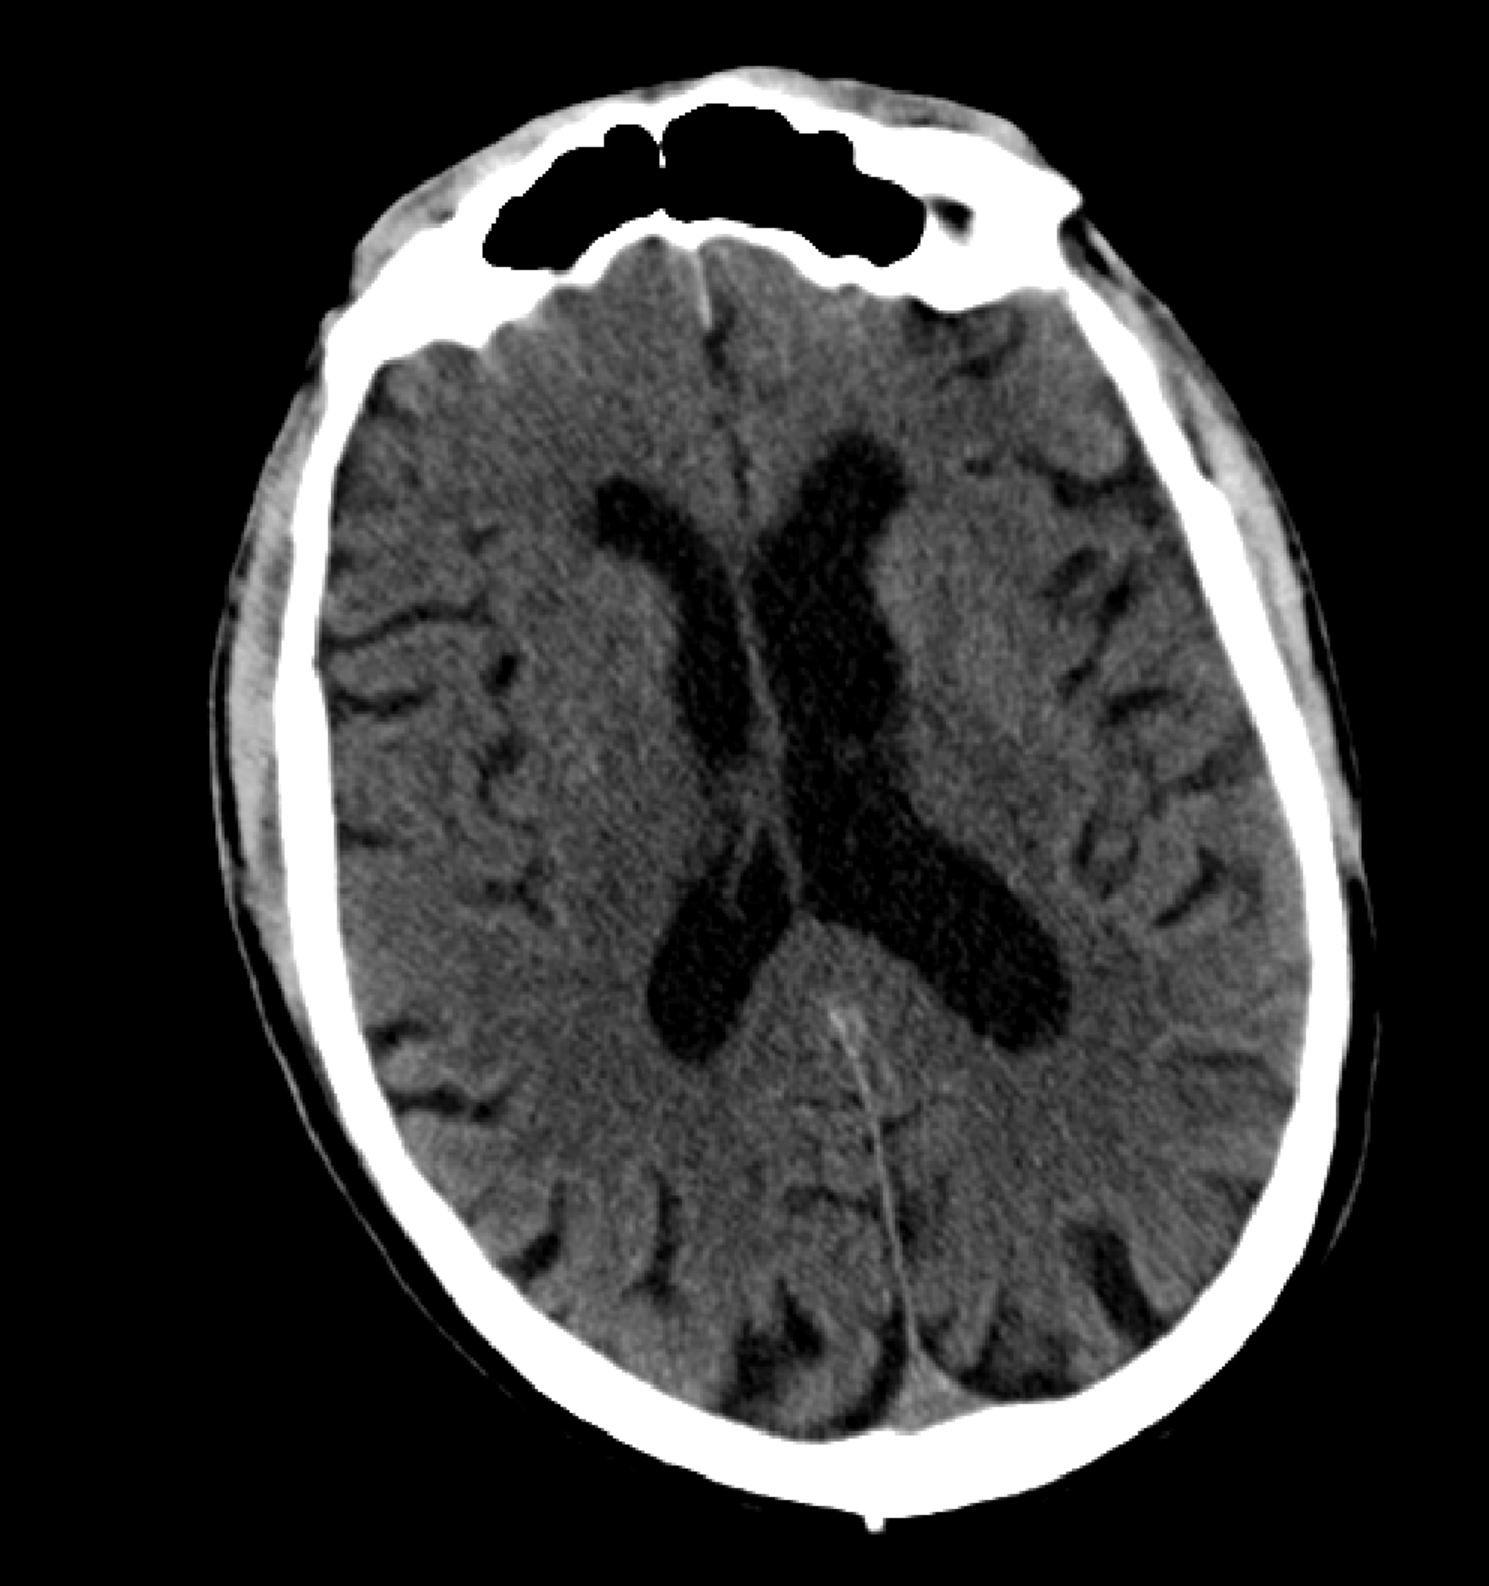

Now let's put it into our [CTobj class](https://github.com/DIDSR/pediatricIQphantoms/blob/main/src/pediatricIQphantoms/make_phantoms.py#L19) from [pediatricIQphantoms](https://github.com/DIDSR/pediatricIQphantoms/tree/main) for more consistent functionality

In [17]:
from utils import CTobj

ctobj = CTobj(phantom, spacings=(dz, dx, dy), fov=250)

ctobj.run()

ctobj

ctshow(ctobj.recon[10].squeeze())

import pydicom
from datetime import datetime

ctobj.write_to_dicom('test/no_lesion/test.dcm')

## Now add a lesion

In [18]:
lut = material_lut[~material_lut['CT Number [HU]'].isna()]

In [19]:
lut['xcist material'].unique()

array(['CSF', 'white_matter', 'gray_matter', nan, 'ncat_skull'],
      dtype=object)

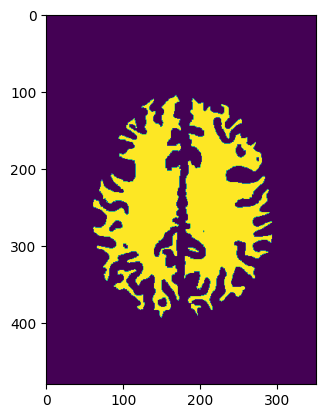

In [20]:
material = 'white_matter'
plt.imshow(phantom[300]==lut.loc[lut['xcist material']==material]['CT Number [HU]'].iloc[1])

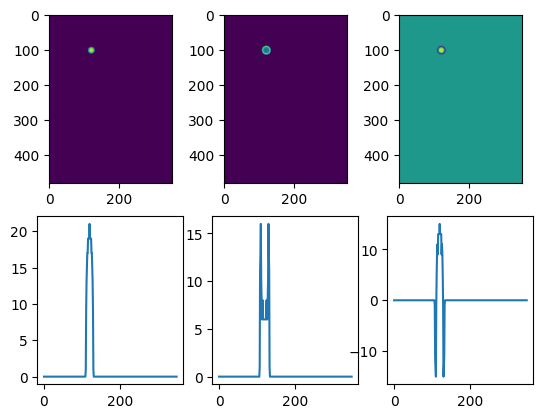

In [21]:
from utils import add_sphere, add_random_sphere_lesion

sphere = add_sphere(phantom, center=(110, 100, 120), radius=10)
annulus = add_sphere(phantom, center=(110, 100, 120), radius=13) ^ sphere

sphere_w_halo = sphere.astype(int) - annulus.astype(int)

f, axs = plt.subplots(2,3)
axs[0,0].imshow(sphere.sum(axis=1))
axs[0,1].imshow(annulus.sum(axis=1))
axs[0,2].imshow(sphere_w_halo.sum(axis=1))

axs[1,0].plot(sphere.sum(axis=1)[100,:])
axs[1,1].plot(annulus.sum(axis=1)[100,:])
axs[1,2].plot(sphere_w_halo.sum(axis=1)[100,:])

In [22]:
def add_random_sphere_lesion(vol:np.ndarray, mask:np.ndarray, radius:list[int]=[20], contrast:list[int]=[-100]):

    if not isinstance(radius, list):
        radius = [radius]
    if not isinstance(contrast, list):
        contrast = [contrast]
    r = max(radius)
    volume = (4/3*np.pi*r**3)*0.95

    counts = 0
    sphere = np.zeros_like(vol, dtype=bool)
    while np.sum(mask & sphere) < volume: #can increase threshold to size of lesion
        lesion_vol = np.zeros_like(vol)
        z, x, y = np.argwhere(mask)[np.random.randint(0, mask.sum())]
        if mask[z].sum() < np.pi*r**2:
            continue
        counts += 1
        sphere = add_sphere(vol, center=(z, x, y), radius=r).transpose(1, 0, 2)
        if counts > 20:
            raise ValueError("Failed to insert lesion into mask")
    
    lesion_vol = np.zeros_like(vol)
    for ri in radius:
        for ci in contrast:
            sphere = add_sphere(vol, center=(z, x, y), radius=ri).transpose(1, 0, 2)
            lesion_vol[sphere] += ci
    img_w_lesion = vol + lesion_vol
    return img_w_lesion, lesion_vol, (z, x, y)

(313, 262, 135)


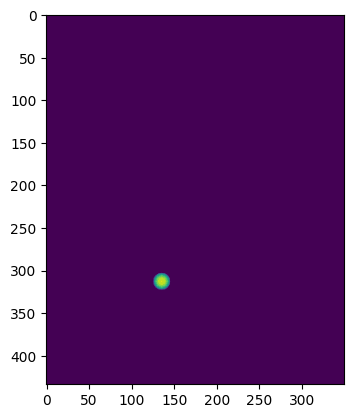

In [23]:
radius = 10
contrast = 20
material = 'white_matter'

ground_truth_image = phantom

brain_mask = ground_truth_image==lut.loc[lut['xcist material']==material]['CT Number [HU]'].iloc[1]
              
img_w_lesion, lesion_image, lesion_coords = add_random_sphere_lesion(ground_truth_image, brain_mask, radius=radius, contrast=contrast)
print(lesion_coords)
plt.imshow(lesion_image.sum(axis=1))

Now we can add in annuli of different contrasts mimicing lesions

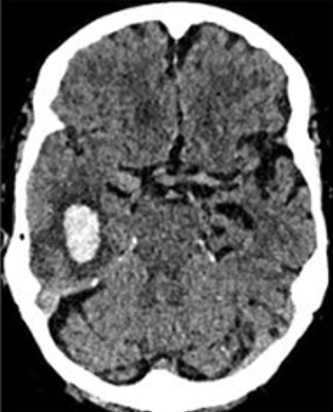

(280, 142, 139)


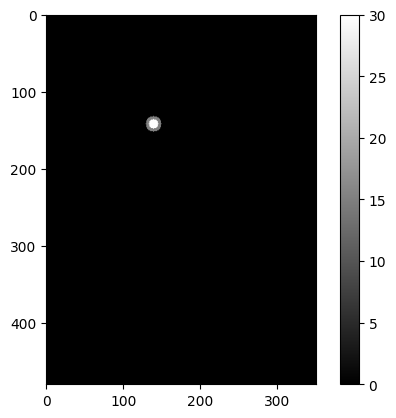

In [24]:
radius = [6, 10]
contrast = [20, -5]
material = 'white_matter'

ground_truth_image = phantom

brain_mask = ground_truth_image==lut.loc[lut['xcist material']==material]['CT Number [HU]'].iloc[1]
              
img_w_lesion, lesion_image, lesion_coords = add_random_sphere_lesion(ground_truth_image, brain_mask, radius=radius, contrast=contrast)
print(lesion_coords)
plt.imshow(lesion_image[lesion_coords[0]], cmap='gray')
plt.colorbar()

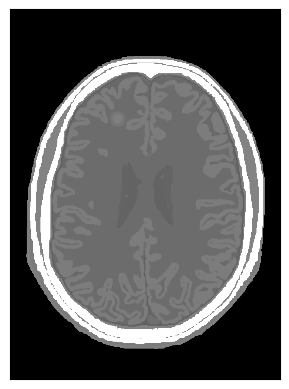

In [25]:
ctshow(img_w_lesion[lesion_coords[0]])

In [26]:
scrollview(img_w_lesion)

interactive(children=(IntSlider(value=217, description='idx', max=433), Output()), _dom_classes=('widget-inter…

detector_width = ct.scanner.detectorRowCount * ct.scanner.detectorRowSize
magnification = ct.scanner.sdd / ct.scanner.sid
detector_width_at_isocenter = detector_width / magnification
valid_slices = int(detector_width_at_isocenter // ct.recon.sliceThickness - 2) # remove one at each end to avoid cone beam artifacts
ct.cfg.recon.sliceCount = valid_slices

In [27]:
from utils import CTobj, add_random_sphere_lesion

In [28]:
ctobj_lesion = CTobj(img_w_lesion, spacings=(dz, dx, dy), patientname='small phantom with lesion')

Initializing Scanner object...
----------
*
*********************************************
* DICOM dataset information:
* Patient age: 000Y, sex: O
* Scanner: GE MEDICAL SYSTEMS RHAPSODE
* Study date & desciption: 20040119, e+1
* Technique: 120 kVp, 170 mA
* Reconstruction: STANDARD kernel, 338.671600-mm FOV
* Image: 0.5-mm pixels (XY), 0.5-mm slices (Z)
*********************************************
*
*********************************************
* Segmentation parameters:
* Using thresholds specified in the config file.
* Materials: ['ICRU_lung_adult_healthy', 'ICRU_adipose_adult2', 'water', 'ICRU_liver_adult', 'ICRU_skeleton_cortical_bone_adult']
* mu values (/cm): [0.05, 0.19, 0.21, 0.22, 0.6]
* mu(water) (/cm): 0.21
* Thresholds (/cm): [0.0, 0.16, 0.21, 0.23, 0.27]
* Thresholds (HU): [-1000.0, -200.0, 0.0, 100.0, 300.0]
*********************************************
* Calculating volume fraction maps for 5 materials and 434 slices...
* Writing volume fraction files for 5 materials an

Based on the size of the phantom we can get an estimate of how many scans are required to cover it, from there we can either keep the full range or modify accordingly

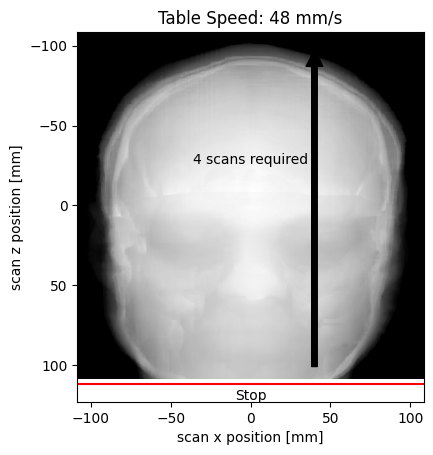

In [29]:
ctobj_lesion.scout_view(table_speed='Intermediate')

Arrow indicates table direction, it translates here with the base of the skull moving vertically

For a quick test let's do 1 scan so adjust the extent accordingly

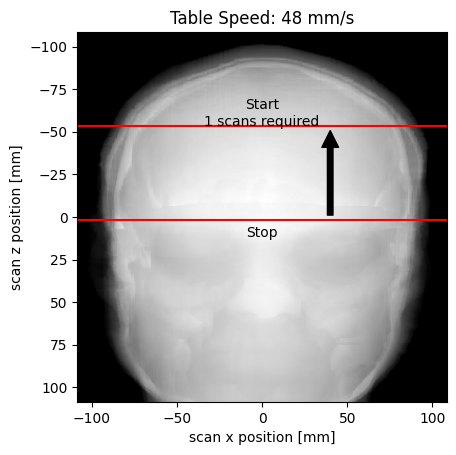

In [30]:
ctobj_lesion.scout_view(startZ=-75, endZ=1, table_speed='Intermediate')

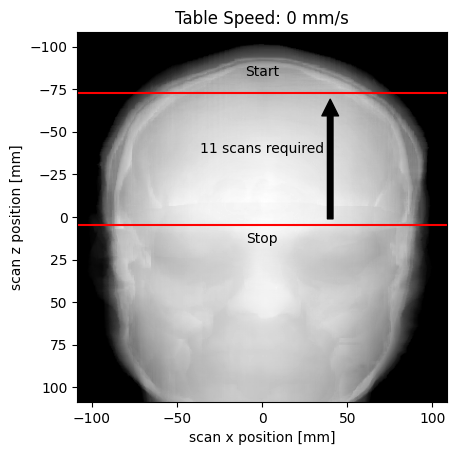

In [31]:
ctobj_lesion.scout_view(startZ=-75, endZ=1, table_speed=0)

Look at how much faster we can scan with helical mode!

Still unclear how to do recon in helical mode...

there is 
```python
ctobj_lesion.xcist.cfg.recon.reconType = 'helical_equiAngle'
```

as discussed here: https://github.com/xcist/main/issues/61#issuecomment-1955840993



In [32]:
ctobj_lesion.xcist.cfg.protocol.tableSpeed

0

In [33]:
ctobj_lesion.run_scan(mA=500, startZ=-75, endZ=1, views=100)

scan: 1/11
Airscan
Offset scan
Phantom scan
phantom scan view loop...


  0%|                                                                                                                                                                                                                                                | 0/100 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated memory for image volume for material  5
in C> Copying data for material  5 into C memory...in C>  done.
in C> Allocated a total of   1390 MB.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.48s/it]


Prep view
Applying LSC...done.

Simulation is done.
scan: 2/11
Airscan
Offset scan
Phantom scan
phantom scan view loop...


  0%|                                                                                                                                                                                                                                                | 0/100 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated memory for image volume for material  5
in C> Copying data for material  5 into C memory...in C>  done.
in C> Allocated a total of   1390 MB.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]


Prep view
Applying LSC...done.

Simulation is done.
scan: 3/11
Airscan
Offset scan
Phantom scan
phantom scan view loop...


  0%|                                                                                                                                                                                                                                                | 0/100 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated memory for image volume for material  5
in C> Copying data for material  5 into C memory...in C>  done.
in C> Allocated a total of   1390 MB.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]


Prep view
Applying LSC...done.

Simulation is done.
scan: 4/11
Airscan
Offset scan
Phantom scan
phantom scan view loop...


  0%|                                                                                                                                                                                                                                                | 0/100 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated memory for image volume for material  5
in C> Copying data for material  5 into C memory...in C>  done.
in C> Allocated a total of   1390 MB.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.37s/it]


Prep view
Applying LSC...done.

Simulation is done.
scan: 5/11
Airscan
Offset scan
Phantom scan
phantom scan view loop...


  0%|                                                                                                                                                                                                                                                | 0/100 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated memory for image volume for material  5
in C> Copying data for material  5 into C memory...in C>  done.
in C> Allocated a total of   1390 MB.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]


Prep view
Applying LSC...done.

Simulation is done.
scan: 6/11
Airscan
Offset scan
Phantom scan
phantom scan view loop...


  0%|                                                                                                                                                                                                                                                | 0/100 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated memory for image volume for material  5
in C> Copying data for material  5 into C memory...in C>  done.
in C> Allocated a total of   1390 MB.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]


Prep view
Applying LSC...done.

Simulation is done.
scan: 7/11
Airscan
Offset scan
Phantom scan
phantom scan view loop...


  0%|                                                                                                                                                                                                                                                | 0/100 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated memory for image volume for material  5
in C> Copying data for material  5 into C memory...in C>  done.
in C> Allocated a total of   1390 MB.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.36s/it]


Prep view
Applying LSC...done.

Simulation is done.
scan: 8/11
Airscan
Offset scan
Phantom scan
phantom scan view loop...


  0%|                                                                                                                                                                                                                                                | 0/100 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated memory for image volume for material  5
in C> Copying data for material  5 into C memory...in C>  done.
in C> Allocated a total of   1390 MB.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]


Prep view
Applying LSC...done.

Simulation is done.
scan: 9/11
Airscan
Offset scan
Phantom scan
phantom scan view loop...


  0%|                                                                                                                                                                                                                                                | 0/100 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated memory for image volume for material  5
in C> Copying data for material  5 into C memory...in C>  done.
in C> Allocated a total of   1390 MB.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.35s/it]


Prep view
Applying LSC...done.

Simulation is done.
scan: 10/11
Airscan
Offset scan
Phantom scan
phantom scan view loop...


  0%|                                                                                                                                                                                                                                                | 0/100 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated memory for image volume for material  5
in C> Copying data for material  5 into C memory...in C>  done.
in C> Allocated a total of   1390 MB.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.35s/it]


Prep view
Applying LSC...done.

Simulation is done.
scan: 11/11
Airscan
Offset scan
Phantom scan
phantom scan view loop...


  0%|                                                                                                                                                                                                                                                | 0/100 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated memory for image volume for material  5
in C> Copying data for material  5 into C memory...in C>  done.
in C> Allocated a total of   1390 MB.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.34s/it]

Prep view
Applying LSC...done.

Simulation is done.


<class 'utils.CTobj'> default

In [34]:
# ctobj_lesion._projections = [str(Path(o).absolute()) for o in ctobj_lesion._projections]

In [35]:
ctobj_lesion.xcist.resultsName

'simulation_test'

In [36]:
ctobj_lesion._projections

['simulation_test',
 'simulation_test',
 'simulation_test',
 'simulation_test',
 'simulation_test',
 'simulation_test',
 'simulation_test',
 'simulation_test',
 'simulation_test',
 'simulation_test',
 'simulation_test']

In [37]:
ctobj_lesion.run_recon()

fov size: 250.0
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
* Writing the recon results to one big file...
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
* Writing the recon results to one big file...
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon resul

<class 'utils.CTobj'> default
Recon: (77, 512, 512) 25.0 cm fov
Projections: (100, 16, 900)

ctobj_lesion.xcist.cfg.recon.reconType = 'helical_equiAngle'
ctobj_lesion.xcist.cfg.recon.reconType

ctobj_lesion.xcist.cfg.recon.sliceThickness = 1
ctobj_lesion.xcist.cfg.recon.sliceCount = int(ctobj_lesion.scan_width / ctobj_lesion.xcist.cfg.recon.sliceThickness)
ctobj_lesion.run_recon(sliceCount=40)

In [38]:
scrollview(ctobj_lesion.recon)

interactive(children=(IntSlider(value=38, description='idx', max=76), Output()), _dom_classes=('widget-interac…

In [39]:
lo_dose

NameError: name 'lo_dose' is not defined

In [ ]:
scrollview(ctobj_lesion.recon.transpose(2,1, 0))

In [ ]:
lo_dose = ctobj_lesion.recon

In [ ]:
im = ctshow(lo_dose[-1]+20, 'brain')
plt.colorbar(im)

In [ ]:
scrollview(lo_dose)

### Rescan at a higher dose

In [ ]:
ctobj_lesion.run_scan(mA=500, startZ=-50, endZ=-44, views=100)

In [ ]:
ctobj_lesion.run_recon(fov=200)

In [ ]:
hi_dose = ctobj_lesion.recon

In [ ]:
scrollview(hi_dose)

In [ ]:
f, ax = plt.subplots(dpi=150)
im = ctshow(np.concatenate([hi_dose[-1], lo_dose[-1]], axis=1)+20, 'brain', fig=f,ax=ax)
plt.colorbar(im)
plt.title('Hi Dose 500 mA | Lo Dose 200 mA') 

## Now Low kV

In [ ]:
import gecatsim as xc

In [ ]:
ctobj_lesion.run_scan(mA=500, kVp=80, startZ=-50, endZ=-44, views=100)

In [ ]:
lo_kV = ctobj_lesion.recon

In [ ]:
scrollview(lo_kV)

In [ ]:
ctobj_lesion.start_positions = ctobj_lesion.calculate_start_positions()
ctobj_lesion.scout_view(startZ=-50, endZ=-39, slice_thickness=5)

In [ ]:
ctobj_lesion.run_scan(startZ=-50, endZ=-39, views=100)

In [ ]:
f, ax = plt.subplots(dpi=150)
im = ctshow(np.concatenate([hi_dose[-1], lo_kV[-1]], axis=1)+20, fig=f,ax=ax)
plt.colorbar(im)
plt.title('120 kV | 80 kV') 

### Short Scan of Full Volume

In [ ]:
ctobj_lesion.start_positions = ctobj_lesion.calculate_start_positions()
ctobj_lesion.scout_view(startZ=-95, endZ=75)

In [ ]:
ctobj_lesion.run_scan(startZ=-95, endZ=75, views=100)

In [ ]:
stacked_recon = ctobj_lesion.recon

In [ ]:
scrollview(stacked_recon)

There should be a better way to do helical to cover more brain fast but for now I dont know how to do it...

ctobj_lesion.xcist.cfg.protocol.viewCount = 500
ctobj_lesion.xcist.protocol.stopViewId = ctobj_lesion.xcist.cfg.protocol.startViewId+ctobj_lesion.xcist.cfg.protocol.viewCount-1

ctobj_lesion.xcist.cfg.protocol.rotationTime

ctobj_lesion.xcist.cfg.protocol.viewsPerRotation = 50

ctobj_lesion.xcist.cfg.protocol.tableSpeed = 1

nrviews = ctobj_lesion.xcist.cfg.protocol.viewCount
zshifts = np.arange(nrviews)*ctobj_lesion.xcist.cfg.protocol.tableSpeed*ctobj_lesion.xcist.cfg.protocol.rotationTime/ctobj_lesion.xcist.cfg.protocol.viewsPerRotation
zshifts.shape

zshifts[0], zshifts[-1]

ctobj_lesion.xcist.run_all()

ctobj_lesion.xcist.cfg.recon.sliceCount = 40
ctobj_lesion.xcist.cfg.recon.sliceThickness = 1

from gecatsim.reconstruction.pyfiles import recon
recon.recon(ctobj_lesion.xcist.cfg)

from dxcist.xcist_sims import get_reconstructed_data
test_helical_recon = get_reconstructed_data(ctobj_lesion.xcist)
test_helical_recon.shape

scrollview(test_helical_recon)

Has something to do with setting the zshift [see here](https://github.com/xcist/main/blob/4d0e50f016558c4bb64efd413d594925d0f00570/gecatsim/dose/pyfiles/catdoserecon.py#L116). This would make it easier to redo the reconstruction across a whole volume

In [ ]:
nib.save(nib.Nifti1Image(stacked_recon, np.eye(4)), 'sparse_view_MIDA.nii')

In [ ]:
scrollview(stacked_recon.transpose(2, 0, 1))

In [ ]:
ctshow(img_w_lesion[lesion_coords[0]])
plt.imshow(lesion_image[lesion_coords[0]], 'Reds', alpha=0.25)

In [ ]:
from utils import center_crop, center_crop_like

In [ ]:
f, axs = plt.subplots(1,2, dpi=150)
ctshow(center_crop(img_w_lesion[lesion_coords[0]]), fig=f, ax=axs[0])
axs[0].imshow(center_crop_like(lesion_image[lesion_coords[0]], img_w_lesion[lesion_coords[0]]), 'Reds', alpha=0.25)

offset=20
scaled_lesion_loc = int(np.ceil(stacked_recon[offset:].shape[0] - lesion_coords[0]/img_w_lesion.shape[0] * stacked_recon[offset:].shape[0] + offset))
ctshow(center_crop(stacked_recon[scaled_lesion_loc]), fig=f, ax=axs[1])

In [ ]:
ctobj_lesion.recon = stacked_recon

Can use table startZ to translate and acquire repeat axial slices!

In [ ]:
import pydicom
from datetime import datetime
ctobj_lesion.write_to_dicom('test/test_lesion.dcm');

## Full View Single View

In [ ]:
ctobj_lesion.start_positions = ctobj_lesion.calculate_start_positions()
ctobj_lesion.scout_view(startZ=-40, endZ=-34)

In [ ]:
ctobj_lesion.run_scan(startZ=-40, endZ=-34, views=1000)

In [ ]:
full_scan = ctobj_lesion.recon

In [ ]:
scrollview(full_scan)

In [ ]:
ctshow(full_scan[-1]+20, 'brain')

In [ ]:
f, ax = plt.subplots(dpi=150)
im = ctshow(np.concatenate([hi_dose[-0], full_scan[-0]], axis=1)+20, 'brain', fig=f,ax=ax)
# plt.colorbar(im)
plt.title('short scan | full scan') 

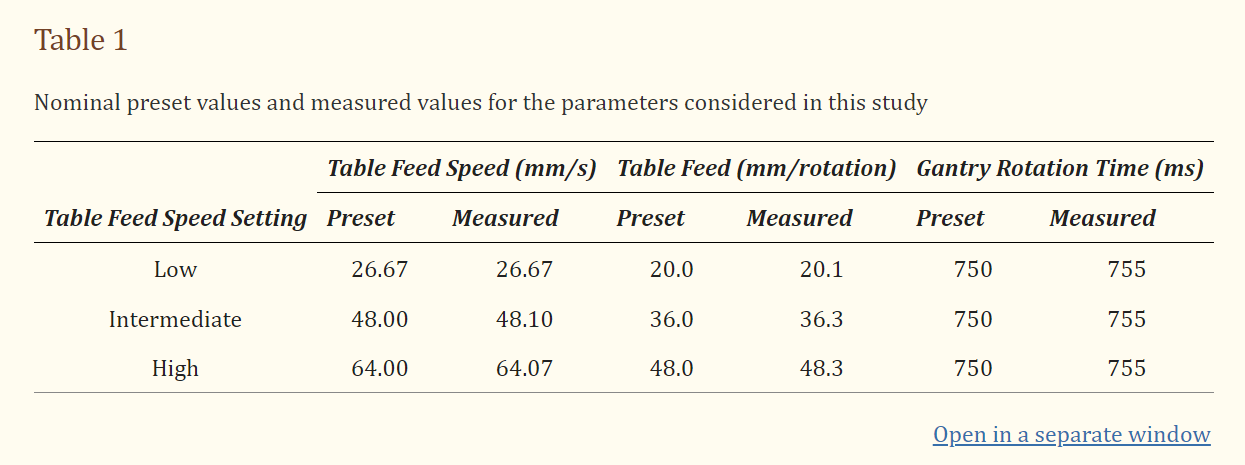

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5711061/

In [ ]:
table_speed = 48 # medium, mm/s

In [ ]:
table_speed = {'Low': 26.67, 'Intermediate': 48, 'High': 64} # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5711061/

Params to change: 1. views per rotation, 2. table speed, 3. total scan length

In [ ]:
ctobj_lesion.xcist.cfg.protocol.viewsPerRotation = 100
ctobj_lesion.xcist.cfg.protocol.tableSpeed = table_speed['Intermediate']
ctobj_lesion.total_scan_length, ctobj_lesion.xcist.cfg.protocol.tableSpeed, ctobj_lesion.xcist.cfg.protocol.viewsPerRotation

Don't edit below, these are the calculations

In [ ]:
zcoverage_per_scan = ctobj_lesion.xcist.cfg.protocol.rotationTime * ctobj_lesion.xcist.cfg.protocol.tableSpeed
rotations_required = ctobj_lesion.total_scan_length / zcoverage_per_scan
zcoverage_per_scan, rotations_required

In [ ]:
ctobj_lesion.xcist.cfg.protocol.tableSpeed = 0
print(len(ctobj_lesion.calculate_start_positions(ctobj_lesion)))

ctobj_lesion.xcist.cfg.protocol.tableSpeed = table_speed['Low']
print(len(ctobj_lesion.calculate_start_positions(ctobj_lesion)))

ctobj_lesion.xcist.cfg.protocol.tableSpeed = table_speed['Intermediate']
print(len(ctobj_lesion.calculate_start_positions(ctobj_lesion)))

ctobj_lesion.xcist.cfg.protocol.tableSpeed = table_speed['High']
print(len(ctobj_lesion.calculate_start_positions(ctobj_lesion)))

In [ ]:
ctobj_lesion.xcist.cfg.protocol.viewCount = np.ceil(ctobj_lesion.xcist.cfg.protocol.viewsPerRotation*rotations_required).astype(int)
ctobj_lesion.xcist.cfg.protocol.stopViewId = ctobj_lesion.xcist.cfg.protocol.startViewId + ctobj_lesion.xcist.cfg.protocol.viewCount - 1
ctobj_lesion.xcist.cfg.protocol.stopViewId 

In [ ]:
ctobj_lesion.xcist.cfg.protocol.viewCount, ctobj_lesion.xcist.cfg.protocol.viewsPerRotation, ctobj_lesion.xcist.protocol.startZ

In [ ]:
ctobj_lesion.xcist.protocol.tableSpeed

In [ ]:
ctobj_lesion.xcist.run_all()

In [ ]:
from dxcist.xcist_sims import get_projection_data, get_reconstructed_data

In [ ]:
proj = get_projection_data(ctobj_lesion.xcist)
proj.shape

In [ ]:
ctobj_lesion.xcist.cfg.recon.sliceThickness = 5
ctobj_lesion.xcist.cfg.recon.sliceCount= int(ctobj_lesion.total_scan_length // (ctobj_lesion.xcist.cfg.recon.sliceThickness/2))
ctobj_lesion.xcist.cfg.recon.sliceCount

In [ ]:
from gecatsim.reconstruction.pyfiles import recon
recon.recon(ctobj_lesion.xcist.cfg)

In [ ]:
scrollview(get_reconstructed_data(ctobj_lesion.xcist))

In [ ]:
nib.save(nib.Nifti1Image(hi_dose, np.eye(4)), 'sparse_view.nii')

In [ ]:
nib.save(nib.Nifti1Image(full_scan, np.eye(4)), 'full_view.nii')

There are viewer aliasing streaks in the full scan

## TODOS

1.  [X] multislice e.g.

```python
ctobj = CTobj(phantom[290:310], fov=250)
```

The current issue with multislice is I am converting ground truth to a [single dicom file](https://github.com/bnel1201/Virtual-Patient-CT-Simulations/blob/PedSilicoICH-Pilot/xcist_sims.py#L152), whereas i should save as a list of dicom files in a directory, as done in the [xcist examples](https://github.com/xcist/phantoms-voxelized/tree/main/DICOM_to_voxelized/example_abdomen_DICOMs_Philips/manifest-1647351635516/TCGA-OV/TCGA-09-2043/12-26-1999-NA-CT%20Abdo%20UnEnhan-12438/3.000000-CEAxial3.0WITH%20CE-03364) - format is 1-001.dcm, 1-002.dcm,..., then in the [phantom cfg file give a slice range](https://github.com/xcist/phantoms-voxelized/blob/main/DICOM_to_voxelized/DICOM_to_voxelized_phantom.py#L107).

2. [ ] fix water atten value such that CT numbers are correct (currently a small negative bias, eg brain rois around -20 HU when  they should be +20 HU)
3. [ ] Merge MIRT and CATSim as different subclasses of CTobj so its easy to switch between the two (the first step of making a ground truth phantom with attenuation coefficients is the same)
   - I don't think MIRT is going to work with oct2py because the [wtfmex](https://web.eecs.umich.edu/~fessler/irt/irt/mex/oct/mi64/) compiled matlab/octave file gives en invalid ELF header, which indicates it needs to be recompiled and I dont have access to the source code
   - It looks like there is good progress at [Julia Image Recon](https://github.com/JuliaImageRecon), however CT examples are still missing.  I do not need another backend, XCIST is fine for now and is widely use.
4. [ ] demonstrate with segmented MRIs for more diversity and patient numbers (segmentations should include skull, gray matter and white matter and csf)
5. [ ] Fork [xcist](https://github.com/xcist/main) and make that the new dxcist that i import for pedsilicoICH. Need to be clear about what value I add:
   - more easy to run full volumes automatically with the logic in CTobj.run_scan
   - scout view for previewing distance
   - exporting to DICOM
   - notebook examples
   - More documentation is clearly needed for xcist, its a steep learning curve).
   - Need to carefully study the [xcist/main/gecatsim/examples](https://github.com/xcist/main/tree/master/gecatsim/examples) to make sure I'm not missing anything, there's even a [GUI](https://github.com/xcist/main/blob/master/gecatsim/gui/gui.py)!
7. [ ] start replacing/adding XCIST options to pediatricIQphantoms simulators
8. [X] 3D sphere lesion (make report to team),
9. [ ] more proper IQ assessment and fine tuning using the [digital image quality phantoms](https://github.com/DIDSR/pediatricIQphantoms)
10. [ ] consider JOSS article or related on this method, maybe a med phys tech report
11. [ ] explore more subjects by exploring labeled/segmented MRI datasets
    - https://neuromorphometrics.com/Seg/html/segmentation/cerebral_white_matter.html
      or MRI segmentation networks: https://www.sciencedirect.com/science/article/abs/pii/S0010482522008472
      https://journals.sagepub.com/doi/10.1177/0972753121990175
      - [human brain atlas](https://hba.neura.edu.au/datasets/t1w/)
12. [ ] As Nirmal mentioned I could get far just doing a BUNCH of simulations under different conditions with different lesions, locations etc, I can do a lot witht the MIDA phantom as is and work on different heads later
13. [ ] For lesion ground truth I could do a single material, no noise, faster scan with only the lesion then it will also be in the correct coordinate system
14. [ ] update the CTobj class to read in projection data (including the indices from different regions to recon at different thicknesses, kernels, etc.)
15. [ ] Update ct obj to store paths to saved orojections, recons and ground truth and uave a lazy load methld so that it feels like its loaded into memory 
16. [ ] Update ct obj recon metho ld to re lrecon all projection data using those indices to more easily rerecon the whole scan length (this is probably already possible in xcost but its unclear and undocumented so ill do it this way for now with these seroes of axial scans which is slower but works
17. [ ] Find hrct lung scans to run sims for ghada
18. [ ] Write sharepoint news uodate and upload head ct dicoms directly to sharepoint to use the native viewer. Reauest input on ideas for mri as ground truth but for now can use the mida head for first round


Explore Papaya, maybe use as a SharePoint browser? Seemed simple enough to install git clone https://github.com/rii-mango/Papaya.git the bash papaya-builder.sh